In [1]:
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys

if is_interactive():
    %matplotlib inline
    sys.path.append('../')

import numpy
from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap
from experiments.visualizations import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

random_state = 7
numpy.random.seed(random_state)

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '+', '-', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

Using Theano backend.


# 1.a. Load data with weak labels

In [2]:
from experiments.data import load_webs

dataset_name = 'webs'

only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                random_state=random_state,
                                                folder='../data/')

X_w, Z_w, z_w, Y_w, y_w = only_weak
X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true

n_classes = Y_wt.shape[1]
n_features = X_w.shape[1]

print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))

../experiments/data.py:162: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y_val = dfY[categories].as_matrix()
../experiments/data.py:176: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Z_val = dfZ.iloc[indices_val][categories].as_matrix().astype(int)
../experiments/data.py:181: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Z_train = dfZ[mask_train][categories].as_matrix().astype(int)


Number of features = 2099
Number of classes = 6
Class names = ['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other']


# 1.c. Save true labels for testing

In [3]:
prop_test = 0.5
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

val_indx, test_indx = next(sss.split(X_wt, y_wt))
print('Weak labels: Training original partition size = {}'.format(len(z_wt)))
print('True labels: Validation original partition size = {}'.format(len(val_indx)))
print('True labels: Test original partition size = {}'.format(len(test_indx)))
# test partition
X_wt_test, Z_wt_test, z_test = X_wt[test_indx], Z_wt[test_indx], z_wt[test_indx]
Y_wt_test, y_wt_test = Y_wt[test_indx], y_wt[test_indx]
# Validation partition
X_wt_val, Z_wt_val, z_wt_val = X_wt[val_indx], Z_wt[val_indx], z_wt[val_indx]
Y_wt_val, y_wt_val = Y_wt[val_indx], y_wt[val_indx]
print('True labels: Validation partition size = {}'.format(len(y_wt_val)))
print('True labels: Test partition size = {}'.format(len(y_wt_test)))

Weak labels: Training original partition size = 1249
True labels: Validation original partition size = 624
True labels: Test original partition size = 625
True labels: Validation partition size = 624
True labels: Test partition size = 625


# 1.d. Sample of weak and true labels

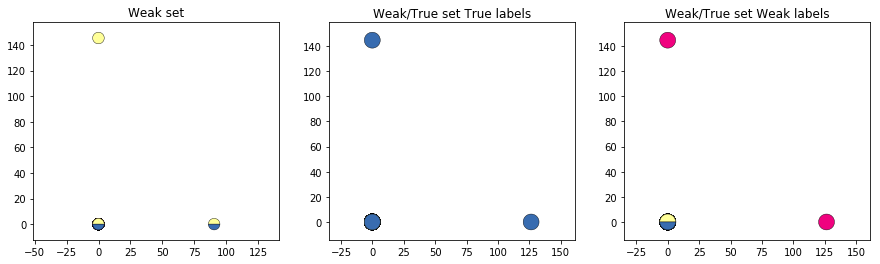

In [4]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100, ], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt[:100], Y_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt[:100], Z_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 2.a. Train Scikit learn baselines

A Logistic Regression trained with only validation true labels (624 samples)
Accuracy = 0.7136


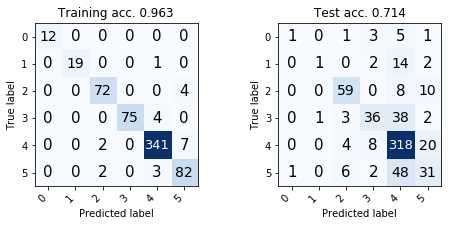

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [5]:
max_epochs = 2000

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
LR.fit(X_wt_val, y_wt_val)
print('A Logistic Regression trained with only validation true labels ({} samples)'.format(y_wt_val.shape[0]))
acc_lowerbound = LR.score(X_wt_test, y_wt_test)
print('Accuracy = {}'.format(acc_lowerbound))

fig = plt.figure(figsize=(8,3))
clf_pred =  LR.predict(X_wt_val)
cm = confusion_matrix(y_wt_val, clf_pred)
acc = (y_wt_val == clf_pred).mean()
ax = fig.add_subplot(1, 2, 1)
_ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

clf_pred =  LR.predict(X_wt_test)
cm = confusion_matrix(y_wt_test, clf_pred)
acc = (y_wt_test == clf_pred).mean()
ax = fig.add_subplot(1, 2, 2)
_ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

# 2.b. Train Keras baselines


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import regularizers

_EPSILON = K.epsilon()

def make_model(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros', 
                kernel_regularizer=regularizers.l2(1.0),
                kernel_initializer='glorot_normal'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    return model

from keras.callbacks import EarlyStopping

batch_size = 1024
patience = 100
early_stop_loss = 'val_acc'

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='acc. {:.3}'.format(acc))

## 2.b.2. Lowerbound with a small amount of true labels

A Keras Logistic Regression trained with only validation true labels (624 samples)
Accuracy = 0.672


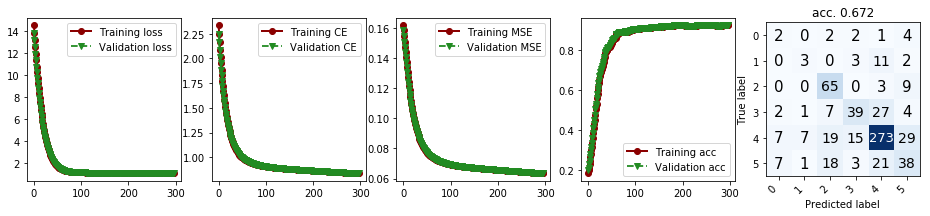

<Figure size 360x288 with 0 Axes>

In [7]:
numpy.random.seed(random_state)
model = make_model('categorical_crossentropy')

history = model.fit(X_wt_val, Y_wt_val, 
                    validation_data=(X_wt_val, Y_wt_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_wt_test, y_wt_test, history)

print('A Keras Logistic Regression trained with only validation true labels ({} samples)'.format(X_wt_val.shape[0]))
acc_lowerbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [8]:
list_weak_proportions = numpy.array([0.0, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 0.7, 1.0])
acc = {}

Number of weak samples = 65912, Accuracy = 0.552

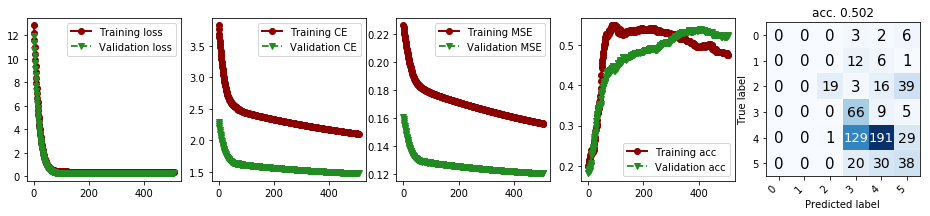

<Figure size 360x288 with 0 Axes>

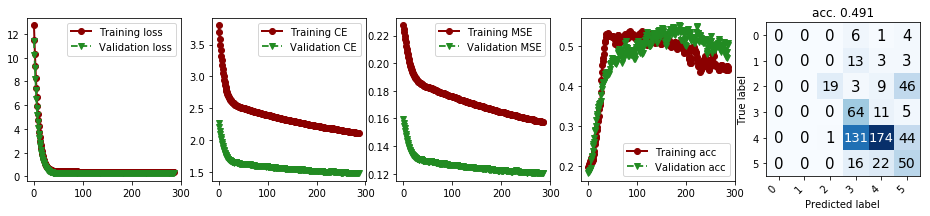

<Figure size 360x288 with 0 Axes>

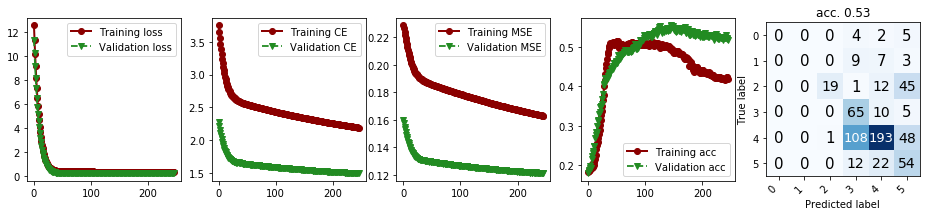

<Figure size 360x288 with 0 Axes>

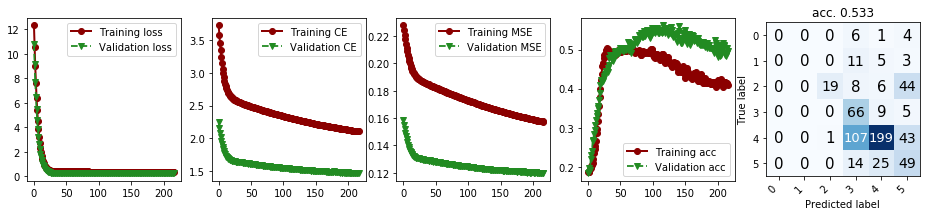

<Figure size 360x288 with 0 Axes>

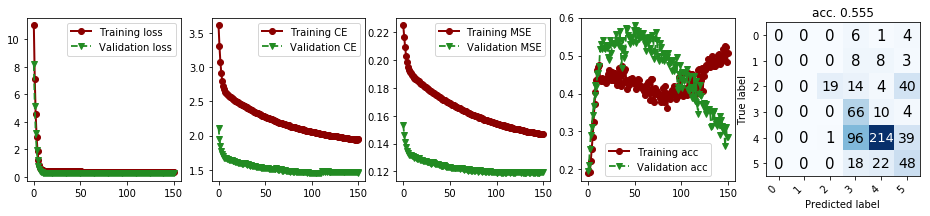

<Figure size 360x288 with 0 Axes>

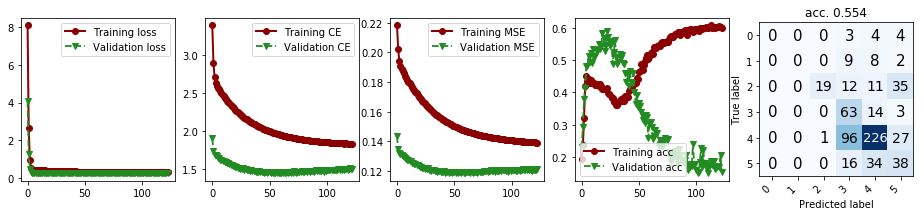

<Figure size 360x288 with 0 Axes>

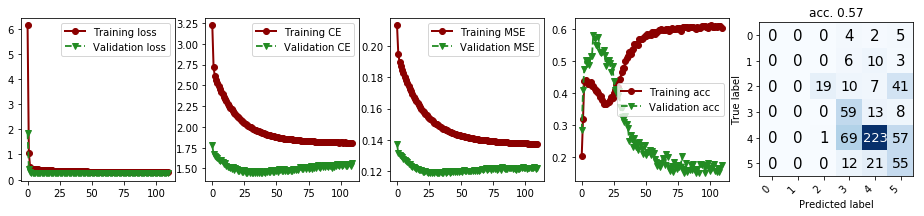

<Figure size 360x288 with 0 Axes>

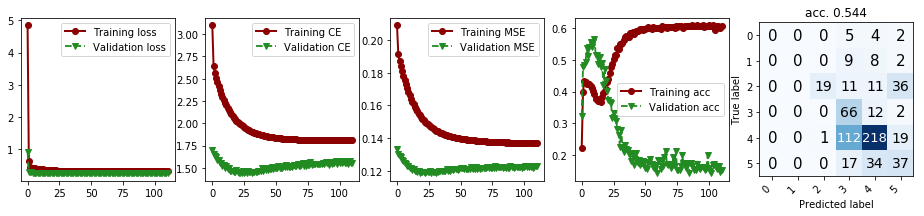

<Figure size 360x288 with 0 Axes>

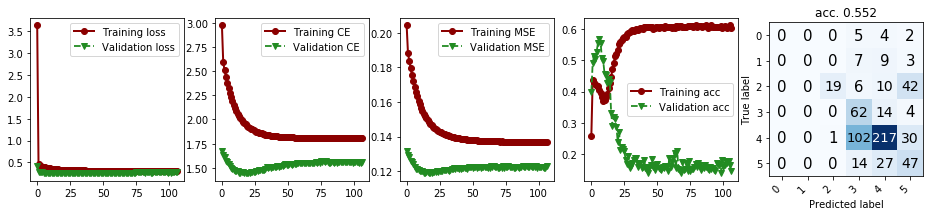

<Figure size 360x288 with 0 Axes>

In [9]:
def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'Weak'
acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    X_w_aux = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)
    Z_w_aux = numpy.concatenate((Z_w[:last_index], Z_wt_val), axis=0)
    numpy.random.seed(random_state)
    
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_w_aux, Z_w_aux,
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

In [10]:
categories = range(n_classes)
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_wt_val, Y_wt_val, range(n_classes), reg='Partial', Z_reg=Z_w)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_w.shape[0] / float(X_w.shape[0] + X_wt_val.shape[0])
q_1 = X_wt_val.shape[0] / float(X_w.shape[0] + X_wt_val.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
M = None
if M is not None:
    # 1.b. True mixing matrix
    M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0 shape = {}\n{}".format(M_0.shape, numpy.round(M_0, decimals=3)))
print("M_1 shape = {}\n{}".format(M_1.shape, numpy.round(M_1, decimals=3)))
print("M_EM shape = {}\n{}".format(M_EM.shape, numpy.round(M_EM, decimals=3)))
print("Z_wt\n{}".format(numpy.round(Z_wt_val[:5])))
print("Y_wt\n{}".format(numpy.round(Y_wt_val[:5])))

q0 = 0.9906216183720091, q1 = 0.009378381627990862
M_0 shape = (64, 6)
[[0.    0.    0.    0.    0.    0.   ]
 [0.233 0.105 0.362 0.144 0.217 0.486]
 [0.033 0.026 0.053 0.021 0.041 0.029]
 [0.    0.    0.    0.    0.    0.   ]
 [0.067 0.079 0.053 0.371 0.024 0.029]
 [0.    0.    0.    0.    0.    0.   ]
 [0.2   0.395 0.213 0.309 0.677 0.314]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.026 0.096 0.01  0.005 0.019]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.026 0.011 0.01  0.003 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.026 0.021 0.01  0.003 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.053 0.011 0.01  0.003 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.026 0.011 0.01  0.003 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.033 0.026 0.011 0.01  0.003 0.01 ]
 [0.    0.    0.    0.    0.    

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = 1


In [11]:
m = {}

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / Q.sum(axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

## 3.c. Train with estimated mixing matrix M_ME

Z_w_index [6 1 1 6 4]
Y_wt_val_index [4 5 4 4 5]
Mixing matrix M shape = (70, 6)
Number of weak samples = 65912, Accuracy = 0.576

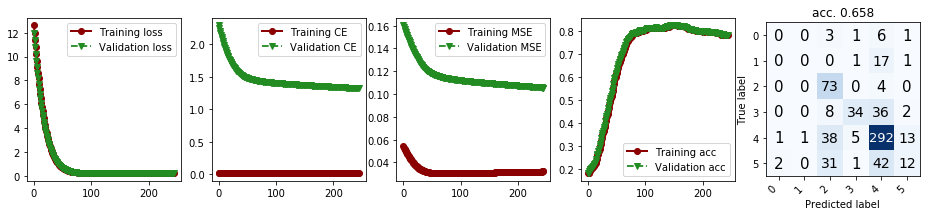

<Figure size 360x288 with 0 Axes>

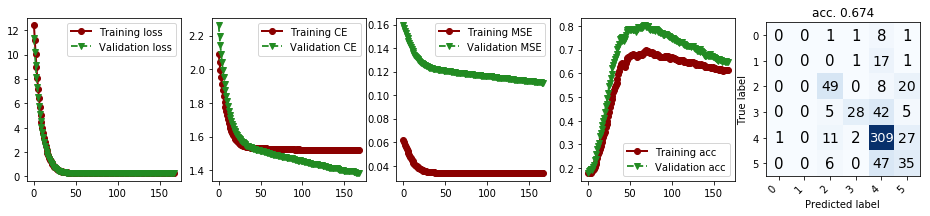

<Figure size 360x288 with 0 Axes>

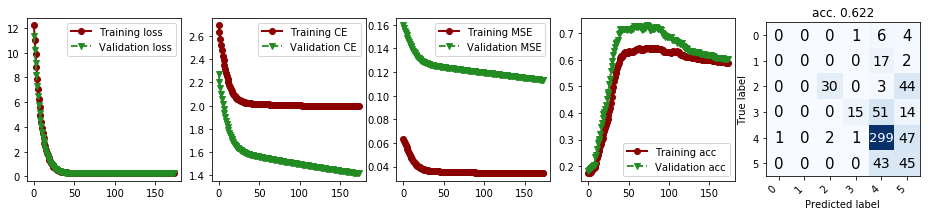

<Figure size 360x288 with 0 Axes>

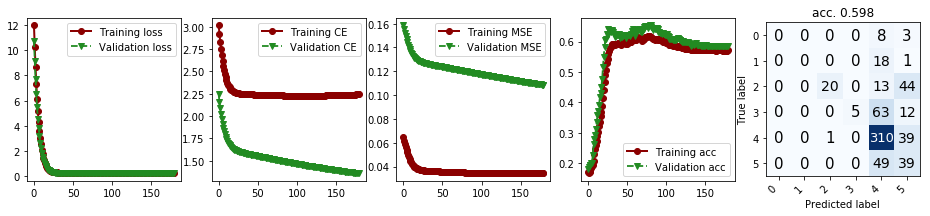

<Figure size 360x288 with 0 Axes>

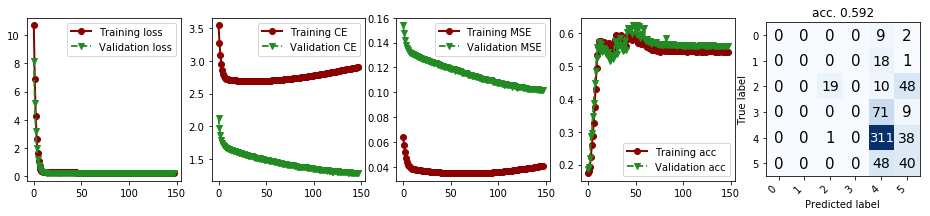

<Figure size 360x288 with 0 Axes>

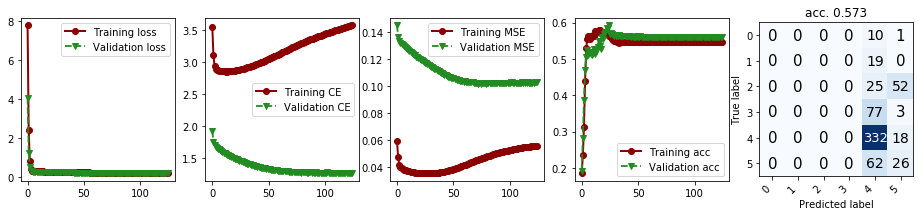

<Figure size 360x288 with 0 Axes>

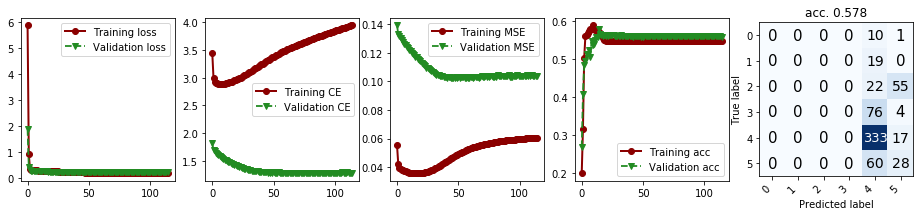

<Figure size 360x288 with 0 Axes>

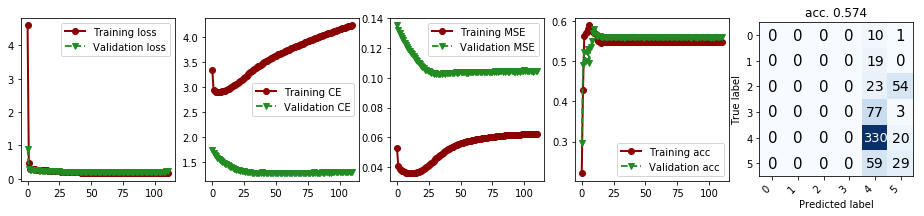

<Figure size 360x288 with 0 Axes>

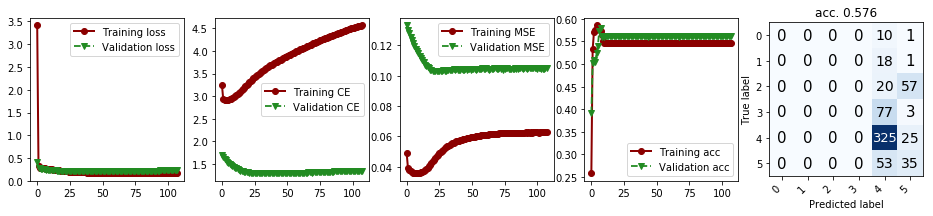

<Figure size 360x288 with 0 Axes>

In [12]:
Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_val_index = weak_to_index(Y_wt_val, method='supervised')
print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_val_index {}'.format(Y_wt_val_index[:5]))

method = 'EM M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    Z_wt_train_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_val_index + M_0.shape[0]))

    X_wt_train_aux = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)

    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_val.shape[0])
    q_1 = X_wt_val.shape[0] / float(last_index + X_wt_val.shape[0])
    M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_wt_train_aux, m[method][Z_wt_train_index], 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

## 4. Baseline Optimistic Superset Learning



Number of weak samples = 65912, Accuracy = 0.400

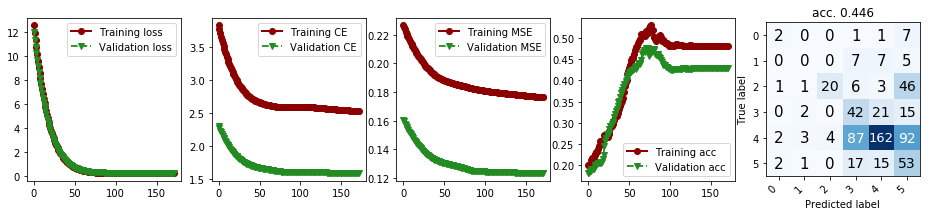

<Figure size 360x288 with 0 Axes>

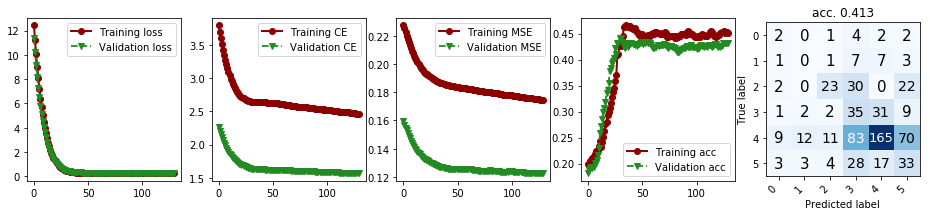

<Figure size 360x288 with 0 Axes>

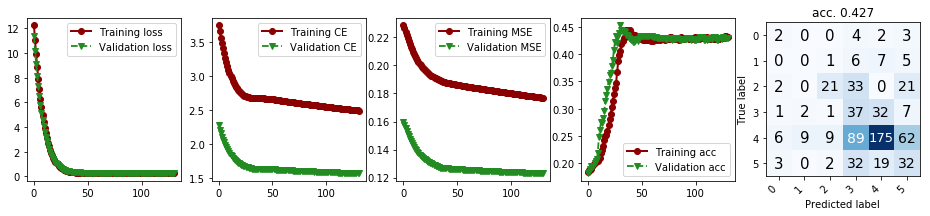

<Figure size 360x288 with 0 Axes>

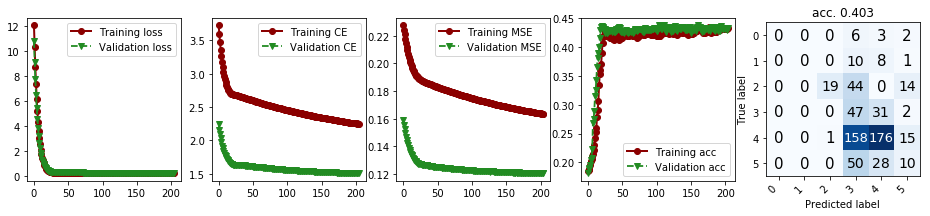

<Figure size 360x288 with 0 Axes>

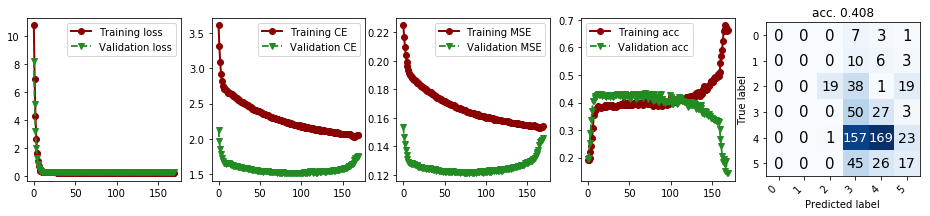

<Figure size 360x288 with 0 Axes>

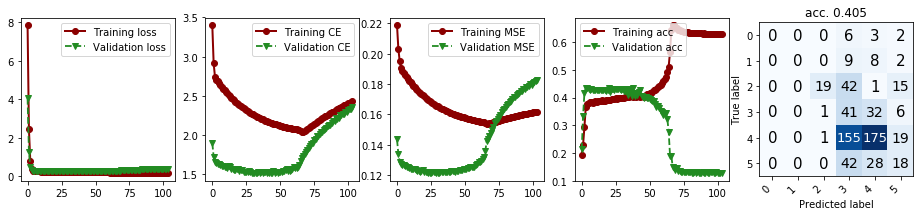

<Figure size 360x288 with 0 Axes>

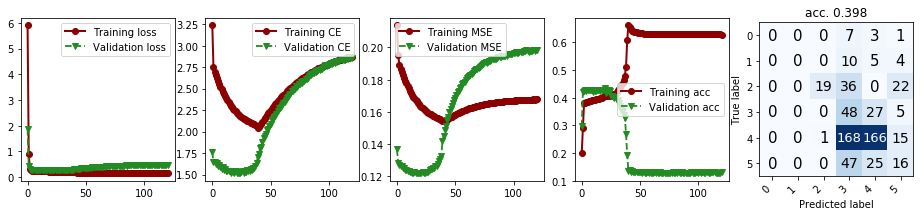

<Figure size 360x288 with 0 Axes>

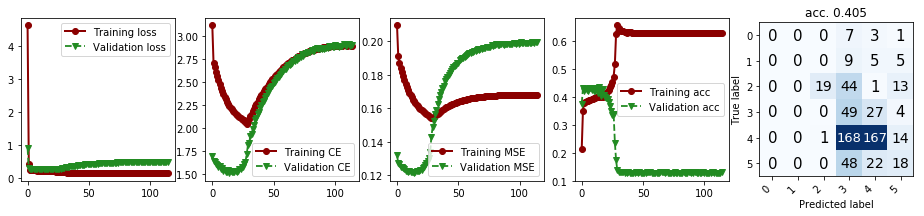

<Figure size 360x288 with 0 Axes>

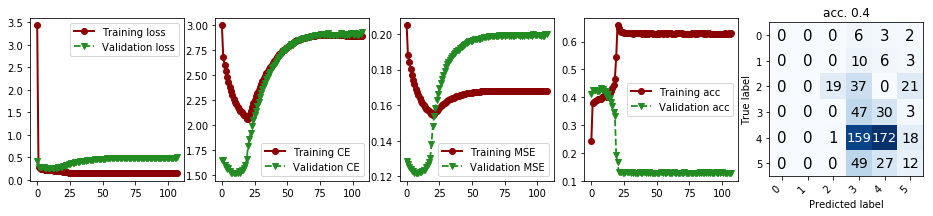

<Figure size 360x288 with 0 Axes>

In [13]:
def OSL_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    O = y_true * y_pred
    S = K.cast(K.equal(O,
                       O.max(axis=-1).repeat(O.shape[-1]
                                            ).reshape((-1, O.shape[-1]))),
               'float32')
    out = -K.stop_gradient(S) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'

acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])

    X_wt_train = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)
    Z_wt_train = numpy.concatenate((Z_w[:last_index], Z_wt_val), axis=0)

    numpy.random.seed(random_state)
    model = make_model(OSL_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_wt_train, Z_wt_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 5. Plot results

Acc. Weak
[0.5024 0.4912 0.5296 0.5328 0.5552 0.5536 0.5696 0.544  0.552 ]
Acc. EM M estimated
[0.6576 0.6736 0.6224 0.5984 0.592  0.5728 0.5776 0.5744 0.576 ]
Acc. OSL
[0.4464 0.4128 0.4272 0.4032 0.408  0.4048 0.3984 0.4048 0.4   ]
Acc. Lowerbound = 0.672


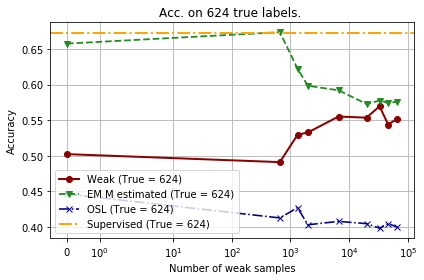

In [14]:
if M is not None:
    print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
if M is not None:
    M_text = '{} $\alpha={:0.1f}$, $\beta={:0.1f}$'.format(M_method, M_alpha, M_beta)
else:
    M_text = ''
ax.set_title(r'Acc. on {} true labels. {}'.format(X_wt_val.shape[0], M_text))
for key, value in acc.items():
    ax.plot(list_weak_proportions*Z_w.shape[0], value, label='{} (True = {})'.format(key, Y_wt_val.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_EM, 'v-', color='blue', label='EM weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_weak, 'x-', color='magenta', label='Weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_OSL, '+-', color='green', label='OSL Weak + {} true labels'.format(Z_v.shape[0]))
if M is not None:
    ax.axhline(y=acc_upperbound, color='red', lw=2,linestyle='--', label='Supervised (True = {})'.format(X_w.shape[0]))
ax.axhline(y=acc_lowerbound, color='orange', lw=2, linestyle='-.', label='Supervised (True = {})'.format(Z_wt_val.shape[0]))
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy')
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
if M is not None:
    M_text = '_{}_a{:02.0f}_b{:02.0f}'.format(M_method, M_alpha, M_beta)
else:
    M_text = ''
fig.savefig('full_vs_em_{}{}.svg'.format(dataset_name, M_text))